In [1]:
%matplotlib inline

In [2]:
import os, glob
from pathlib import Path

import numpy as np
from numpy import nan as NaN
import pandas as pd
import seaborn as sns
import ptitprince as pt
import matplotlib.pyplot as plt 

In [3]:
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
print('seaborn version: ', sns.__version__)
print('ptitprince version: ', '0.2.5')

numpy version:  1.21.5
pandas version:  1.3.5
matplotlib version:  2.2.5
seaborn version:  0.11.2
ptitprince version:  0.2.5


## Code to generate Figure 2D 

**Figure 2D** features the distributions of framewise displacement (in mm) averaged per run (left) and for every frame (right). 

To run the cells, you will need to **pull the following input files**: 
* ***cneuromod-things/THINGS/glmsingle/sub-{s}/qc/sub-{s}_task-things_headmotion.tsv***


In [4]:
mot_file_path = Path("../../THINGS/glmsingle").resolve()
fig_save_path = Path("../figures").resolve()


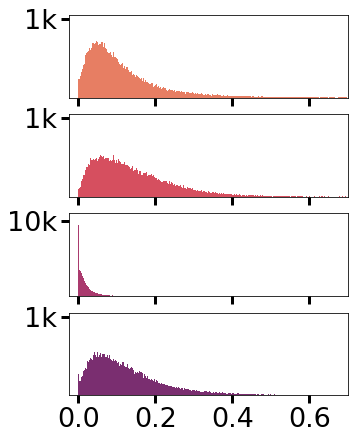

In [5]:
# FD per frame plot

# set to True to export .png file
save_fig = False

SMALL_SIZE = 8
MEDIUM_SIZE = 27
BIGGER_SIZE = 40

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, axes = plt.subplots(4, 1, figsize=(5, 7))

sub_list = ['01', '02', '03', '06']
colors = [
    (0.90732341, 0.4939774, 0.38990532),
    (0.83765537, 0.30784814, 0.3723105),
    (0.66635279, 0.22717328, 0.43008427),
    (0.47936222, 0.18006056, 0.43733022),
]

for i in range(len(sub_list)):
    sub_num = sub_list[i]
    sub_df = pd.read_csv(
        f"{mot_file_path}/sub-{sub_num}/qc/sub-{sub_num}_task-things_headmotion.tsv",
        sep = '\t',
    ).dropna()
    raw_data = sub_df['framewise_displacement'].to_numpy() 
        
    axes[i].hist(sub_df['framewise_displacement'], bins=np.arange(0, 0.7, 0.0025), color=colors[i])
    axes[i].set_xlim((-0.025, 0.7))
    axes[i].set_xticks(ticks=[0.0, 0.2, 0.4, 0.6])
    axes[i].tick_params(width=3, size=8)
    
    if i == 2:
        axes[i].set_ylim((0, 11000))
        axes[i].set_yticks(ticks=[10000])
        axes[i].set_yticklabels(['10k'])
    else:
        axes[i].set_yticklabels(['0.9k'])
        axes[i].set_ylim((0, 1050))
        axes[i].set_yticks(ticks=[1000])
        axes[i].set_yticklabels(['1k'])
        
    if i == 3:
        axes[i].set_xticklabels([0.0, 0.2, 0.4, 0.6])
        axes[i].set_xlabel('')
    else:
        axes[i].set_xticklabels([])
        axes[i].set_xlabel('')
            
if save_fig:
    plt.savefig(f"{fig_save_path}/Fig2D_fwd_distribution_perFrame.png", dpi=600, bbox_inches='tight')
plt.show()


In [6]:
# FWD per run plot

# Average motion metrics per run for each subject

flist = sorted(glob.glob(f"{mot_file_path}/sub-*/qc/sub-*_task-things_headmotion.tsv"))

ids = ['subject_id', 'session_id', 'run_id']
col_names = ['framewise_displacement', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
all_sub_means_df = pd.DataFrame(columns=ids + ['mean_framewise_displacement']) 

for file in flist:
    sub_num = os.path.basename(file).split('_')[0][-2:]
    sub_df = pd.read_csv(file, sep = '\t')

    sub_df.insert(loc=0, column='subject_id', value=int(sub_num), allow_duplicates=True)
    
    for sess in np.unique(sub_df['session_id']).tolist():
        df_ses = sub_df[sub_df['session_id'] == sess]
        runs = [x for x in np.unique(df_ses['run_id']).tolist()]
        for r in runs:
            df_run = df_ses[df_ses['run_id'] == r].dropna()
            run_entry = [f'sub-{sub_num}', sess, r, df_run['framewise_displacement'].mean()]
            all_sub_means_df = all_sub_means_df.append(pd.Series(run_entry, index=ids + ['mean_framewise_displacement']), ignore_index=True)


[]

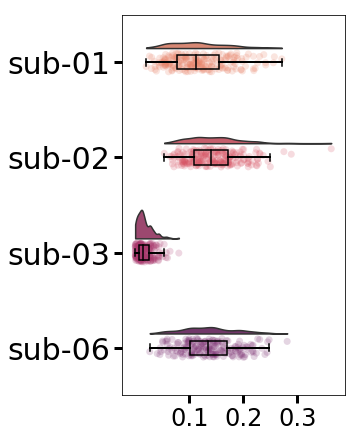

In [7]:
# Make figure

# set to True to export .png file
save_fig = False

SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


df = all_sub_means_df

f, ax = plt.subplots(figsize=(4, 7))

dy="subject_id"; dx="mean_framewise_displacement"; ort="h"; 
pal = sns.color_palette("flare", 4)

ax=pt.half_violinplot(x = dx, y = dy, data = df, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)
ax=sns.stripplot(x = dx, y = dy, data = df, palette = pal, edgecolor = "white",
                 size = 3, alpha=0.2, s=7, jitter = 1, zorder = 0, orient = ort)
    
ax=sns.boxplot(x = dx, y = dy, data = df, color = "black", width = .15, zorder = 10, 
               showcaps = True, boxprops = {'facecolor':'none', "zorder":10},
               showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},
               saturation = 1, orient = ort)

ax.tick_params(width=3, size=8)

plt.xticks([0.1, 0.2, 0.3])
plt.xlabel('')
plt.ylabel('')

if save_fig:
    plt.savefig(f"{fig_save_path}/Fig2D_fd distribution_perRun.png", dpi=600, bbox_inches='tight')
plt.plot()
